In [2]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [4]:
n = 2701  #novel number
t =  'Moby_Dick'#novel name
s = 1 #how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [5]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [6]:
with open('data/novel_'+novel_title+'.csv', 'wb') as f:
    writer = csv.writer(f)
    for sentence in novel_sentences:
        writer.writerow([sentence])

Read in the csv file to pandas

In [7]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [8]:
df_novel.head()

,0
0,The proofreaders of this version are indebted ...
1,The resulting etext was compared with a public...
2,"In chapters 24, 89, and 90, we substituted a c..."
3,ETYMOLOGY.
4,(Supplied by a Late Consumptive Usher to a Gra...


Create the wrd_length and total_char columns.

In [9]:
def wrd_lengths(sentence):
    return [len(word) for word in TextBlob(sentence).words]

In [10]:
df_novel['wrd_length'] = df_novel[0].apply(wrd_lengths)

In [11]:
df_novel['total_char'] = [sum(l) for l in df_novel['wrd_length']]

In [12]:
df_novel.head()

,0,wrd_length,total_char
0,The proofreaders of this version are indebted ...,"[3, 12, 2, 4, 7, 3, 8, 2, 3, 10, 2, 8, 7, 3, 1...",106
1,The resulting etext was compared with a public...,"[3, 9, 5, 3, 8, 4, 1, 6, 6, 4, 4, 7, 2, 3, 4]",69
2,"In chapters 24, 89, and 90, we substituted a c...","[2, 8, 2, 2, 3, 2, 2, 11, 1, 7, 1, 3, 3, 6, 3,...",86
3,ETYMOLOGY.,[9],9
4,(Supplied by a Late Consumptive Usher to a Gra...,"[8, 2, 1, 4, 11, 5, 2, 1, 7, 6, 3, 4, 5, 10, 2...",102


Create syllable count column

In [13]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [14]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [15]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [16]:
df_novel['syl_count'] = syl_count_arr

In [17]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,The proofreaders of this version are indebted ...,"[3, 12, 2, 4, 7, 3, 8, 2, 3, 10, 2, 8, 7, 3, 1...",106,"[1, 4, 1, 1, 2, 1, 2, 1, 1, 5, 1, 3, 3, 1, 3, ..."
1,The resulting etext was compared with a public...,"[3, 9, 5, 3, 8, 4, 1, 6, 6, 4, 4, 7, 2, 3, 4]",69,"[1, 3, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1]"
2,"In chapters 24, 89, and 90, we substituted a c...","[2, 8, 2, 2, 3, 2, 2, 11, 1, 7, 1, 3, 3, 6, 3,...",86,"[1, 2, 0, 0, 1, 0, 1, 3, 1, 3, 0, 1, 1, 2, 1, ..."
3,ETYMOLOGY.,[9],9,[5]
4,(Supplied by a Late Consumptive Usher to a Gra...,"[8, 2, 1, 4, 11, 5, 2, 1, 7, 6, 3, 4, 5, 10, 2...",102,"[2, 1, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 2, 3, 1, ..."


In [18]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create csv file to record syllable count per word. 

In [19]:
d = {}
for l in df_novel[0]:
    sent = TextBlob(l)
    for x in sent.words:
        w = CountSyllables(x)
        d[x] = w

In [20]:
with open('data/novel_'+novel_title+'_syl.csv', 'wb') as f:
    writer = csv.writer(f)
    for row in d.iteritems():
        writer.writerow(row)

Create syllable sum column

In [21]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [22]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [23]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [24]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Create cluster dataframe - remove columns that can't be used

In [25]:
df_cluster = df_novel.drop('wrd_length', 1)

In [26]:
df_cluster = df_cluster.drop('syl_count', 1)

In [27]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,The proofreaders of this version are indebted ...,106,38,0.000000
1,The resulting etext was compared with a public...,69,23,-0.145833
2,"In chapters 24, 89, and 90, we substituted a c...",86,28,0.000000
3,ETYMOLOGY.,9,5,0.000000
4,(Supplied by a Late Consumptive Usher to a Gra...,102,34,-0.255000


Create 20 clusters on scaled data

In [28]:
X = df_cluster.drop(0, axis=1)

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [31]:
df_cluster_20 = df_cluster.copy()

In [32]:
df_cluster_20['cluster'] = km.labels_

In [33]:
df_cluster_20.head()

,0,total_char,syl_sum,sentiment,cluster
0,The proofreaders of this version are indebted ...,106,38,0.000000,5
1,The resulting etext was compared with a public...,69,23,-0.145833,8
2,"In chapters 24, 89, and 90, we substituted a c...",86,28,0.000000,12
3,ETYMOLOGY.,9,5,0.000000,13
4,(Supplied by a Late Consumptive Usher to a Gra...,102,34,-0.255000,8


In [34]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,The proofreaders of this version are indebted ...,106,38,0.000000
1,The resulting etext was compared with a public...,69,23,-0.145833
2,"In chapters 24, 89, and 90, we substituted a c...",86,28,0.000000
3,ETYMOLOGY.,9,5,0.000000
4,(Supplied by a Late Consumptive Usher to a Gra...,102,34,-0.255000


In [35]:
df_cluster_20.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,44.879971,14.043446,0.002851
1,240.857595,76.927215,0.243216
2,55.920904,17.742938,0.489944
3,62.588571,19.657143,-0.508197
4,505.486486,160.540541,0.074667
5,132.407353,41.673529,-0.029548
6,128.184000,40.580800,0.192221
7,172.029032,54.361290,-0.218083
8,62.773764,19.391635,-0.201359


In [36]:
centers = df_cluster_20.groupby('cluster').mean()

Create Scatter plot 

In [37]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

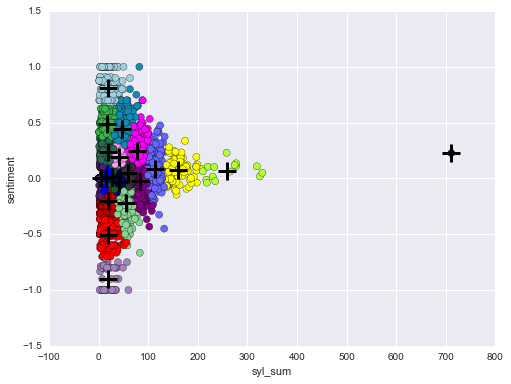

In [38]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster_20.syl_sum, df_cluster_20.sentiment, c=colors[df_cluster_20.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Add cluster_20 to original dataframe

In [39]:
df_novel['cluster_20'] = df_cluster_20['cluster']

In [40]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20
0,The proofreaders of this version are indebted ...,"[3, 12, 2, 4, 7, 3, 8, 2, 3, 10, 2, 8, 7, 3, 1...",106,"[1, 4, 1, 1, 2, 1, 2, 1, 1, 5, 1, 3, 3, 1, 3, ...",38,0.000000,5
1,The resulting etext was compared with a public...,"[3, 9, 5, 3, 8, 4, 1, 6, 6, 4, 4, 7, 2, 3, 4]",69,"[1, 3, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1]",23,-0.145833,8
2,"In chapters 24, 89, and 90, we substituted a c...","[2, 8, 2, 2, 3, 2, 2, 11, 1, 7, 1, 3, 3, 6, 3,...",86,"[1, 2, 0, 0, 1, 0, 1, 3, 1, 3, 0, 1, 1, 2, 1, ...",28,0.000000,12
3,ETYMOLOGY.,[9],9,[5],5,0.000000,13
4,(Supplied by a Late Consumptive Usher to a Gra...,"[8, 2, 1, 4, 11, 5, 2, 1, 7, 6, 3, 4, 5, 10, 2...",102,"[2, 1, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 2, 3, 1, ...",34,-0.255000,8


Create 3 clusters

In [41]:
df_cluster_3 = df_cluster.copy()

In [42]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment
0,The proofreaders of this version are indebted ...,106,38,0.000000
1,The resulting etext was compared with a public...,69,23,-0.145833
2,"In chapters 24, 89, and 90, we substituted a c...",86,28,0.000000
3,ETYMOLOGY.,9,5,0.000000
4,(Supplied by a Late Consumptive Usher to a Gra...,102,34,-0.255000


In [43]:
X = df_cluster_3.drop(0, axis=1)

In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [46]:
df_cluster_3['cluster'] = km.labels_

In [47]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,96.218245,30.484988,0.379615
1,52.932219,16.546890,-0.035464
2,251.652856,79.840426,0.041983


In [48]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,The proofreaders of this version are indebted ...,106,38,0.000000,1
1,The resulting etext was compared with a public...,69,23,-0.145833,1
2,"In chapters 24, 89, and 90, we substituted a c...",86,28,0.000000,1
3,ETYMOLOGY.,9,5,0.000000,1
4,(Supplied by a Late Consumptive Usher to a Gra...,102,34,-0.255000,1


Add cludter_3 to original dataframe

In [49]:
df_novel['cluster_3_syl'] = df_cluster_3['cluster']

In [50]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl
0,The proofreaders of this version are indebted ...,"[3, 12, 2, 4, 7, 3, 8, 2, 3, 10, 2, 8, 7, 3, 1...",106,"[1, 4, 1, 1, 2, 1, 2, 1, 1, 5, 1, 3, 3, 1, 3, ...",38,0.000000,5,1
1,The resulting etext was compared with a public...,"[3, 9, 5, 3, 8, 4, 1, 6, 6, 4, 4, 7, 2, 3, 4]",69,"[1, 3, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1]",23,-0.145833,8,1
2,"In chapters 24, 89, and 90, we substituted a c...","[2, 8, 2, 2, 3, 2, 2, 11, 1, 7, 1, 3, 3, 6, 3,...",86,"[1, 2, 0, 0, 1, 0, 1, 3, 1, 3, 0, 1, 1, 2, 1, ...",28,0.000000,12,1
3,ETYMOLOGY.,[9],9,[5],5,0.000000,13,1
4,(Supplied by a Late Consumptive Usher to a Gra...,"[8, 2, 1, 4, 11, 5, 2, 1, 7, 6, 3, 4, 5, 10, 2...",102,"[2, 1, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 2, 3, 1, ...",34,-0.255000,8,1


Create 3 Clusters with no syl_sum

In [51]:
df_cluster_3no_syl = df_cluster.copy()

In [52]:
df_cluster_3no_syl = df_cluster.drop('syl_sum', 1)

In [53]:
X = df_cluster_3no_syl.drop(0, axis=1)

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [56]:
df_cluster_3no_syl['cluster'] = km.labels_

In [57]:
df_cluster_3no_syl.head()

,0,total_char,sentiment,cluster
0,The proofreaders of this version are indebted ...,106,0.000000,1
1,The resulting etext was compared with a public...,69,-0.145833,1
2,"In chapters 24, 89, and 90, we substituted a c...",86,0.000000,1
3,ETYMOLOGY.,9,0.000000,1
4,(Supplied by a Late Consumptive Usher to a Gra...,102,-0.255000,1


In [58]:
df_cluster_3no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,251.789504,0.046705
1,54.705713,-0.035428
2,95.252280,0.397945


Add cluster_3no_syl to original dataframe

In [59]:
df_novel['cluster_3no_syl'] = df_cluster_3no_syl['cluster']

In [60]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl
0,The proofreaders of this version are indebted ...,"[3, 12, 2, 4, 7, 3, 8, 2, 3, 10, 2, 8, 7, 3, 1...",106,"[1, 4, 1, 1, 2, 1, 2, 1, 1, 5, 1, 3, 3, 1, 3, ...",38,0.000000,5,1,1
1,The resulting etext was compared with a public...,"[3, 9, 5, 3, 8, 4, 1, 6, 6, 4, 4, 7, 2, 3, 4]",69,"[1, 3, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1]",23,-0.145833,8,1,1
2,"In chapters 24, 89, and 90, we substituted a c...","[2, 8, 2, 2, 3, 2, 2, 11, 1, 7, 1, 3, 3, 6, 3,...",86,"[1, 2, 0, 0, 1, 0, 1, 3, 1, 3, 0, 1, 1, 2, 1, ...",28,0.000000,12,1,1
3,ETYMOLOGY.,[9],9,[5],5,0.000000,13,1,1
4,(Supplied by a Late Consumptive Usher to a Gra...,"[8, 2, 1, 4, 11, 5, 2, 1, 7, 6, 3, 4, 5, 10, 2...",102,"[2, 1, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 2, 3, 1, ...",34,-0.255000,8,1,1


Create 5 Clusters

In [61]:
df_cluster_5 = df_cluster.copy()

In [62]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment
0,The proofreaders of this version are indebted ...,106,38,0.000000
1,The resulting etext was compared with a public...,69,23,-0.145833
2,"In chapters 24, 89, and 90, we substituted a c...",86,28,0.000000
3,ETYMOLOGY.,9,5,0.000000
4,(Supplied by a Late Consumptive Usher to a Gra...,102,34,-0.255000


In [63]:
X = df_cluster_5.drop(0, axis=1)

In [64]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [65]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [66]:
df_cluster_5['cluster'] = km.labels_

In [67]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,37.189929,11.560864,0.007486
1,347.877934,110.682316,0.082522
2,159.501204,50.413323,0.047820
3,84.572049,26.848958,0.466849
4,81.724349,25.607963,-0.373914


Add cluster_5 to original dataframe

In [68]:
df_novel['cluster_5'] = df_cluster_5['cluster']

In [69]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
0,The proofreaders of this version are indebted ...,"[3, 12, 2, 4, 7, 3, 8, 2, 3, 10, 2, 8, 7, 3, 1...",106,"[1, 4, 1, 1, 2, 1, 2, 1, 1, 5, 1, 3, 3, 1, 3, ...",38,0.000000,5,1,1,2
1,The resulting etext was compared with a public...,"[3, 9, 5, 3, 8, 4, 1, 6, 6, 4, 4, 7, 2, 3, 4]",69,"[1, 3, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1]",23,-0.145833,8,1,1,0
2,"In chapters 24, 89, and 90, we substituted a c...","[2, 8, 2, 2, 3, 2, 2, 11, 1, 7, 1, 3, 3, 6, 3,...",86,"[1, 2, 0, 0, 1, 0, 1, 3, 1, 3, 0, 1, 1, 2, 1, ...",28,0.000000,12,1,1,0
3,ETYMOLOGY.,[9],9,[5],5,0.000000,13,1,1,0
4,(Supplied by a Late Consumptive Usher to a Gra...,"[8, 2, 1, 4, 11, 5, 2, 1, 7, 6, 3, 4, 5, 10, 2...",102,"[2, 1, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 2, 3, 1, ...",34,-0.255000,8,1,1,4


Write files to csv

In [70]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [71]:
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [72]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
0,The proofreaders of this version are indebted ...,"[3, 12, 2, 4, 7, 3, 8, 2, 3, 10, 2, 8, 7, 3, 1...",106,[1 4 1 1 2 1 2 1 1 5 1 3 3 1 3 1 4 1 2],38,0.000000,5,1,1,2
1,The resulting etext was compared with a public...,"[3, 9, 5, 3, 8, 4, 1, 6, 6, 4, 4, 7, 2, 3, 4]",69,[1 3 2 1 2 1 1 2 2 1 2 2 1 1 1],23,-0.145833,8,1,1,0
2,"In chapters 24, 89, and 90, we substituted a c...","[2, 8, 2, 2, 3, 2, 2, 11, 1, 7, 1, 3, 3, 6, 3,...",86,[1 2 0 0 1 0 1 3 1 3 0 1 1 2 1 1 2 1 1 2 1 3],28,0.000000,12,1,1,0
3,ETYMOLOGY.,[9],9,[5],5,0.000000,13,1,1,0
4,(Supplied by a Late Consumptive Usher to a Gra...,"[8, 2, 1, 4, 11, 5, 2, 1, 7, 6, 3, 4, 5, 10, 2...",102,[2 1 1 1 3 2 1 1 2 1 1 1 2 3 1 1 2 2 1 1 1 1 1 1],34,-0.255000,8,1,1,4


Find ideal amount of clusters for novel

Find Sentiment Pattern 

20 pieces

In [73]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
9975,"Till, gaining that vital centre, the black bub...","[4, 7, 4, 5, 6, 3, 5, 6, 6, 5, 3, 3, 9, 2, 6, ...",206,"[1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 3, ...",64,0.306667,1,2,2,2
9976,"Buoyed up by that coffin, for almost one whole...","[6, 2, 2, 4, 6, 3, 6, 3, 5, 3, 3, 5, 1, 7, 2, ...",79,"[0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",23,0.155556,14,1,1,0
9977,"The unharming sharks, they glided by as if wit...","[3, 9, 6, 4, 6, 2, 2, 2, 4, 8, 2, 5, 6, 3, 6, ...",100,"[1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, ...",28,0.000000,12,1,1,0
9978,"On the second day, a sail drew near, nearer, a...","[2, 3, 6, 3, 1, 4, 4, 4, 6, 3, 6, 2, 2, 2, 4]",52,"[1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1]",19,0.033333,0,1,1,0
9979,"It was the devious-cruising Rachel, that in he...","[2, 3, 3, 16, 6, 4, 2, 3, 9, 6, 5, 3, 7, 8, 4,...",99,"[1, 1, 1, 4, 2, 1, 1, 1, 3, 2, 2, 1, 2, 2, 2, ...",32,-0.100000,12,1,1,0


In [74]:
df_novel['total_char'].sum()

958150

In [75]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - (.06 * (int(len(df_novel) - 1)))
# or figure out some better code. 
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [76]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:594]
df_novel['total_char'][594:1066]
df_novel['total_char'][1066:1523]
df_novel['total_char'][1523:2111]
df_novel['total_char'][2111:2604]
df_novel['total_char'][2604:3049]
df_novel['total_char'][3049:3722]
df_novel['total_char'][3722:4111]
df_novel['total_char'][4111:4486]
df_novel['total_char'][4486:4925]
df_novel['total_char'][4925:5372]
df_novel['total_char'][5372:5847]
df_novel['total_char'][5847:6286]
df_novel['total_char'][6286:6651]
df_novel['total_char'][6651:7092]
df_novel['total_char'][7092:7630]
df_novel['total_char'][7630:8082]
df_novel['total_char'][8082:8581]
df_novel['total_char'][8581:9260]
df_novel['total_char'][9260:9855]


In [77]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
594
0.0574129498448
594
1066
0.0530467527178
1066
1523
0.0791017607445
1523
2111
0.0327304807085
2111
2604
0.0801761709182
2604
3049
0.0609483254891
3049
3722
0.0276241423755
3722
4111
0.0562068100968
4111
4486
0.0532067999619
4486
4925
0.0774542793151
4925
5372
0.0538118949588
5372
5847
0.0494604370775
5847
6286
0.0502416569675
6286
6651
0.0801395796362
6651
7092
0.0326127191025
7092
7630
0.0542611357282
7630
8082
0.0524380119021
8082
8581
0.0271542642209
8581
9260
0.0292053904305
9260
9855
0.0405646104818


In [78]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.05741295  0.05304675  0.07910176  0.03273048  0.08017617  0.06094833
  0.02762414  0.05620681  0.0532068   0.07745428  0.05381189  0.04946044
  0.05024166  0.08013958  0.03261272  0.05426114  0.05243801  0.02715426
  0.02920539  0.04056461]


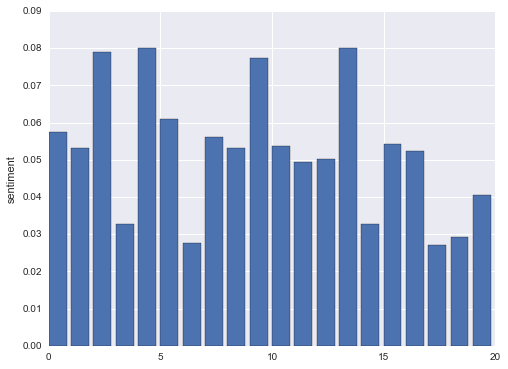

In [79]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern - need to fix this code for the three piece

In [80]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
9975,"Till, gaining that vital centre, the black bub...","[4, 7, 4, 5, 6, 3, 5, 6, 6, 5, 3, 3, 9, 2, 6, ...",206,"[1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 3, ...",64,0.306667,1,2,2,2
9976,"Buoyed up by that coffin, for almost one whole...","[6, 2, 2, 4, 6, 3, 6, 3, 5, 3, 3, 5, 1, 7, 2, ...",79,"[0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",23,0.155556,14,1,1,0
9977,"The unharming sharks, they glided by as if wit...","[3, 9, 6, 4, 6, 2, 2, 2, 4, 8, 2, 5, 6, 3, 6, ...",100,"[1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, ...",28,0.000000,12,1,1,0
9978,"On the second day, a sail drew near, nearer, a...","[2, 3, 6, 3, 1, 4, 4, 4, 6, 3, 6, 2, 2, 2, 4]",52,"[1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1]",19,0.033333,0,1,1,0
9979,"It was the devious-cruising Rachel, that in he...","[2, 3, 3, 16, 6, 4, 2, 3, 9, 6, 5, 3, 7, 8, 4,...",99,"[1, 1, 1, 4, 2, 1, 1, 1, 3, 2, 2, 1, 2, 2, 2, ...",32,-0.100000,12,1,1,0


In [81]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) - (.06 * (int(len(df_novel) - 1)))
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [82]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(0, 3):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:3639]
df_novel['total_char'][3639:6461]
df_novel['total_char'][6461:9967]


In [83]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
3639
0.0541992928233
3639
6461
0.0587585250606
6461
9967
0.0398942047144


In [84]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.05419929  0.05875853  0.0398942 ]


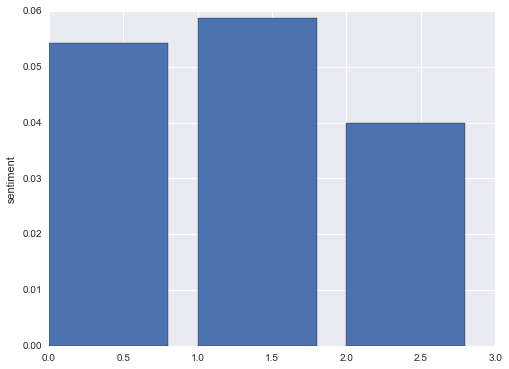

In [85]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers